# Environment

In [8]:
import re
import torch
from pathlib import Path
from random import randint
import pytorch_lightning as pl
from IPython.display import Audio
from helpers.path_utils import get_base_dir
from model import CoraTechDataset, Compose, AddHospitalNoise, Normalize, CoraTechModel
from helpers.plot import compare_audios, plot_wavelet_spectrogram, plot_audio_fft, plot_model_result

CHUNK_SECS = 3
sample_rate = 4000

base_dir = get_base_dir()
TENSORS_DIR = base_dir.joinpath("data", "model", "original")
NOISE_DIR = base_dir.joinpath("data", "hospital-ambient-noise", "original")

# Instance Dataset

In [9]:
transformations = Compose([
    AddHospitalNoise(noise_dir=NOISE_DIR),
    Normalize()
])

cora_dataset = CoraTechDataset(TENSORS_DIR, CHUNK_SECS, transform=transformations)
n_samples = len(cora_dataset)

print(f"Number of samples: {n_samples}")

Number of samples: 187


# Compare heartbeats

#109 / 187
mobile shape, mean and std:  torch.Size([12000]) tensor(0.0003) tensor(0.9571)
stethos shape, mean and std:  torch.Size([12000]) tensor(2.3444e-09) tensor(1.0000)


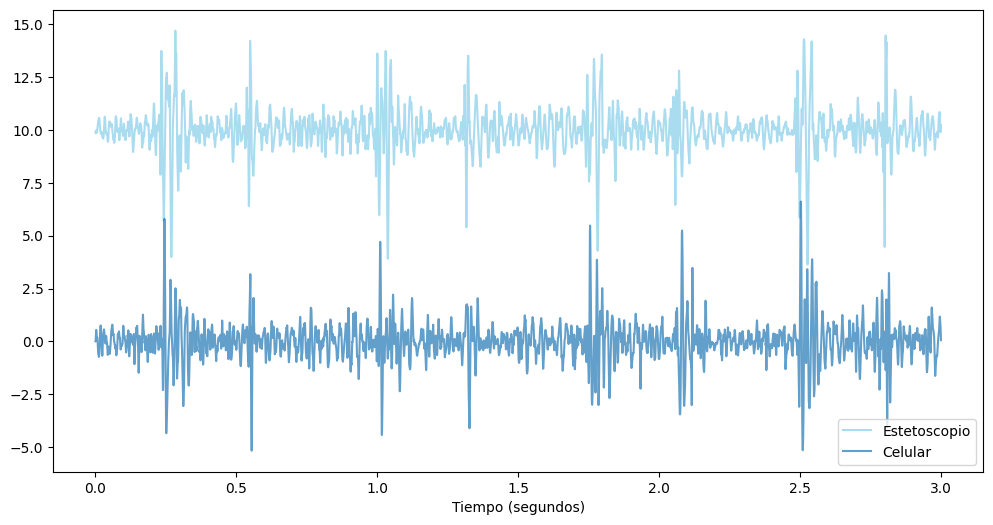

In [10]:
choosen_one = randint(0, n_samples)
choosen_one = 108
print(f"#{choosen_one + 1} / {n_samples}")

mobile_sample, stethos_sample = cora_dataset[choosen_one]

print(
    "mobile shape, mean and std: ",
    mobile_sample.shape,
    mobile_sample.mean(),
    mobile_sample.std(),
)
print(
    "stethos shape, mean and std: ",
    stethos_sample.shape,
    stethos_sample.mean(),
    stethos_sample.std(),
)

compare_audios(mobile_sample, stethos_sample, sample_rate, offset=10)

## Mobile recording

### Without noise

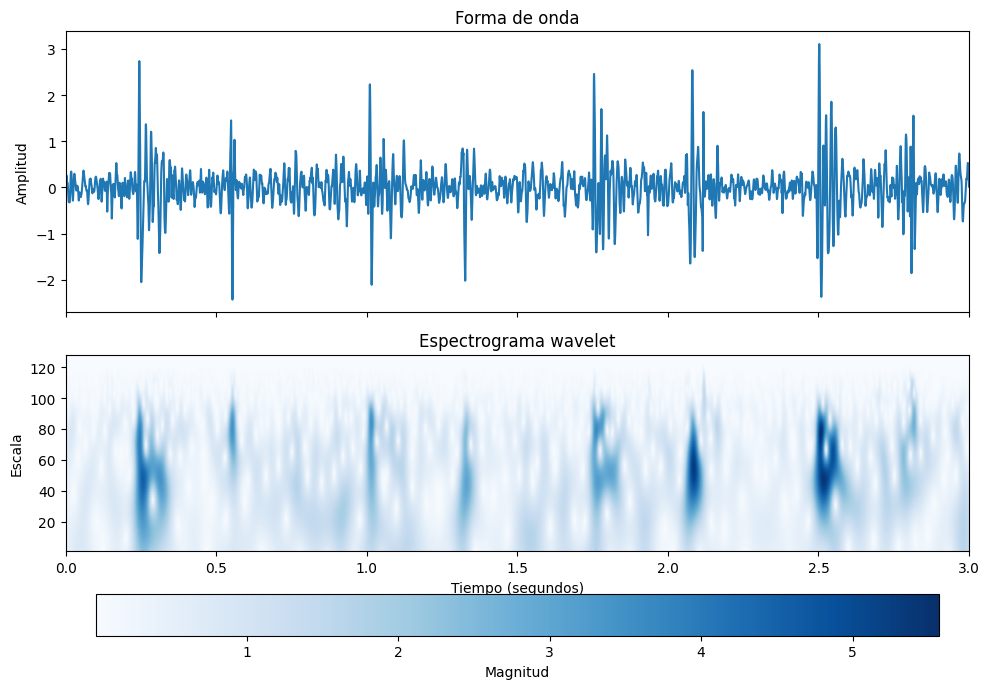

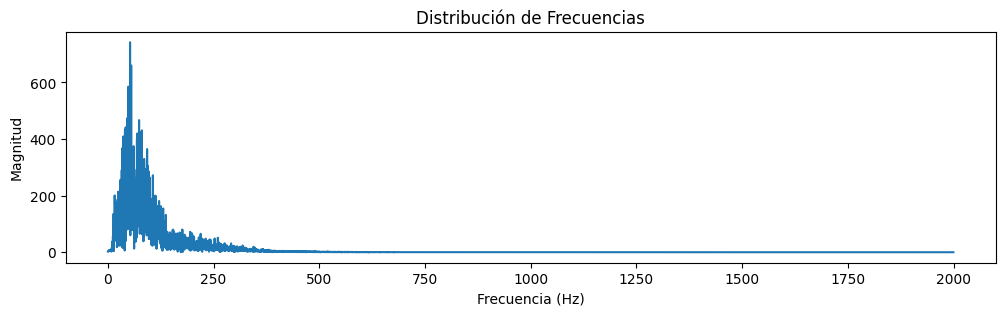

In [11]:
without_noise = CoraTechDataset(TENSORS_DIR, CHUNK_SECS)
mobile_without_noise, _ = without_noise[choosen_one]

plot_wavelet_spectrogram(mobile_without_noise.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_without_noise.numpy(), sample_rate)
Audio(mobile_without_noise, rate=sample_rate, autoplay=True)

### With noise for training

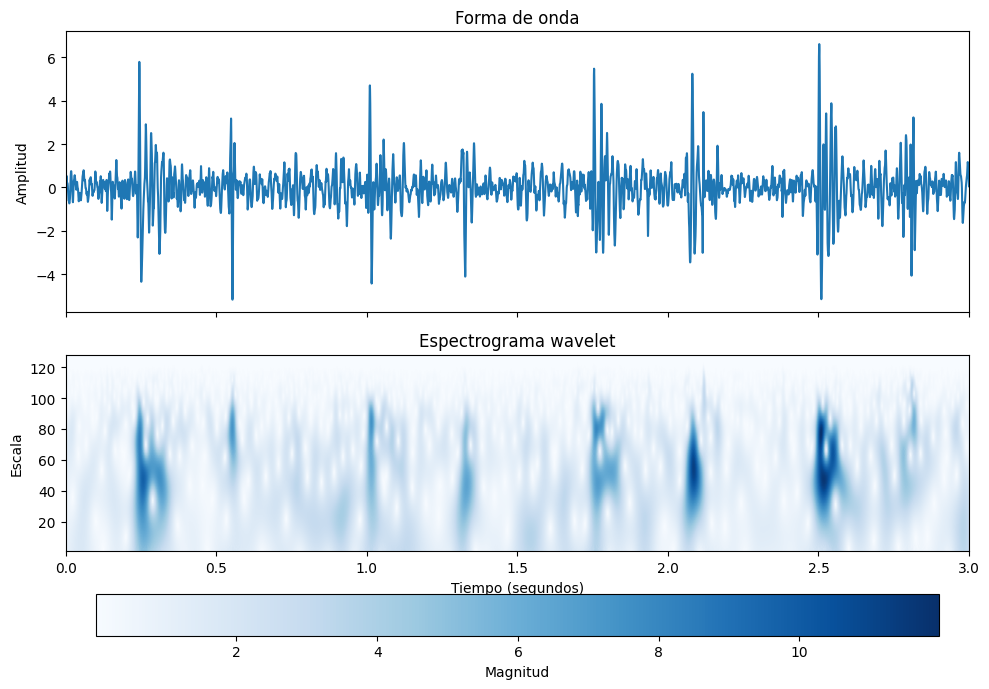

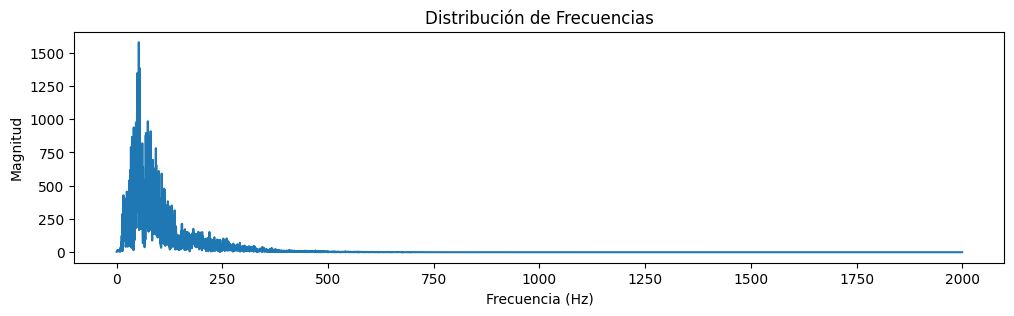

In [12]:
plot_wavelet_spectrogram(mobile_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_sample.numpy(), sample_rate)
Audio(mobile_sample, rate=sample_rate, autoplay=True)

## Stethoscope recording

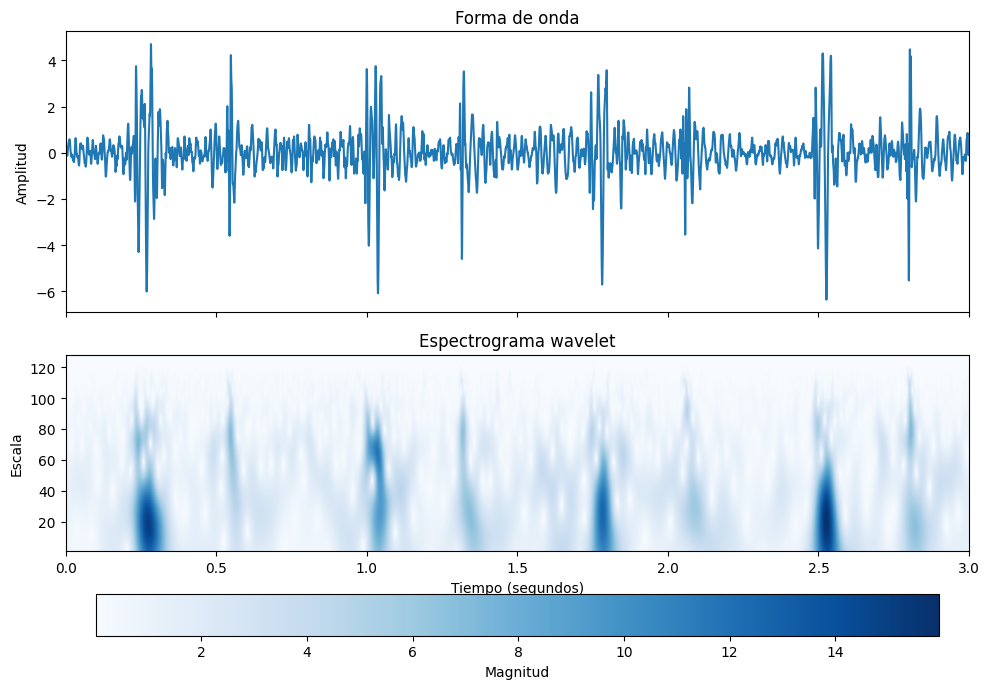

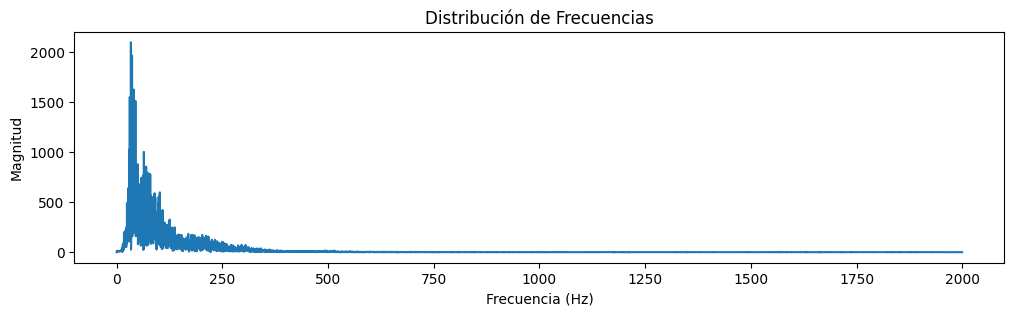

In [13]:
plot_wavelet_spectrogram(stethos_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(stethos_sample.numpy(), sample_rate)
Audio(stethos_sample, rate=sample_rate, autoplay=True)

# Train, validation and test split

In [14]:
batch_size = 15
train_ratio = 0.80
val_ratio = 0.10

train_size = int(train_ratio * len(cora_dataset))
val_size = int(val_ratio * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [15]:
input_secs = mobile_sample.shape[-1] // sample_rate

checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath=f"checkpoints/input-{input_secs}s",
    filename="model-{val_loss:.4f}-{epoch:02d}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Train!

In [ ]:
model = CoraTechModel(input_size=cora_dataset[0][0].shape[-1])

logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

# Predict

## Best model

In [16]:
directory = Path('checkpoints').joinpath(f"input-{input_secs}s")
pattern = r'model-val_loss=([\d\.]+)-epoch=\d+\.ckpt'
val_loss_values = {}

for model_path in directory.iterdir():
    if model_path.is_file():
        match = re.match(pattern, model_path.name)
        if match:
            val_loss = float(match.group(1))
            val_loss_values[model_path] = val_loss

if val_loss_values:
    best_model = min(val_loss_values, key=val_loss_values.get)
    print(f"The {input_secs}s-input model with the lowest validation loss is:\n{best_model.name}\nwith a loss of {val_loss_values[best_model]}")
else:
    print("No models matching the specified pattern were found.")

The 3s-input model with the lowest validation loss is:
model-val_loss=0.5868-epoch=00.ckpt
with a loss of 0.5868


In [17]:
model_to_pred = CoraTechModel(input_size=cora_dataset[0][0].shape[-1])

model_to_pred.load_state_dict(torch.load(best_model)['state_dict'])
model_to_pred.eval()

CoraTechModel(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=12000, bias=True)
)

# Loss in validation set

In [19]:
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch
        predictions = model_to_pred(inputs)
        batch_loss = torch.nn.L1Loss()(predictions, targets)
        total_loss += batch_loss.item()
        num_samples += len(inputs)

mse_loss = total_loss / num_samples
print(f'MAE Loss in test set: {mse_loss:.4f}')

MAE Loss in test set: 0.0583


# Result!

#2 / 2


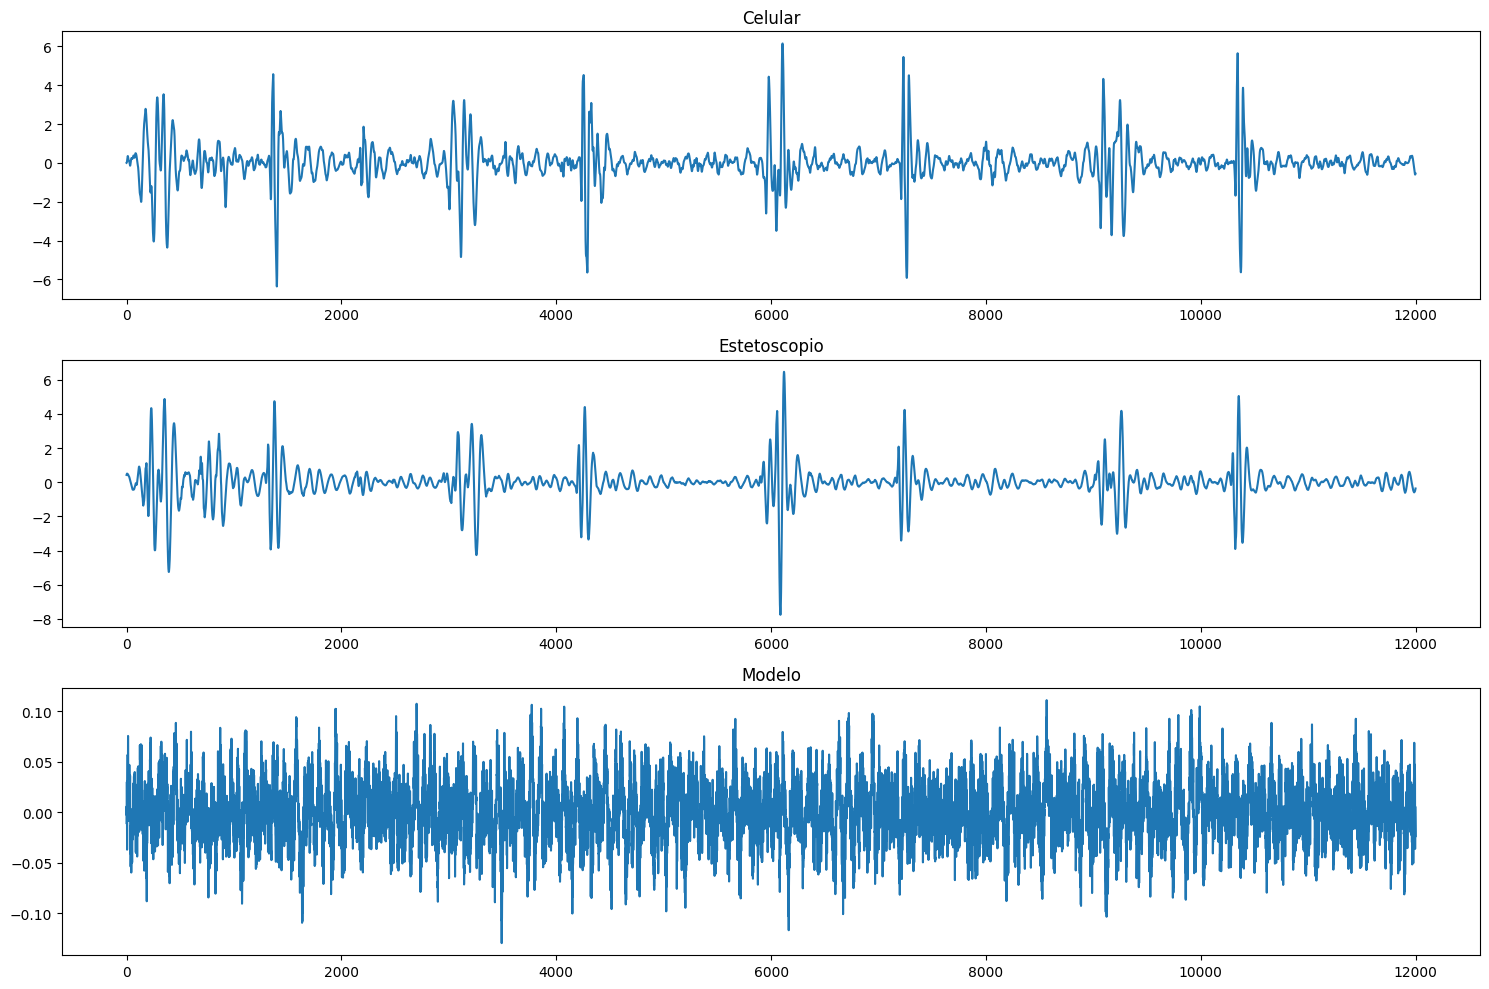

In [22]:
validation_data_length = len(test_dataloader)
choosen_one_pred = randint(0, validation_data_length)

print(f"#{choosen_one_pred} / {validation_data_length}")

model_result = plot_model_result(model_to_pred, test_dataloader, choosen_one_pred)

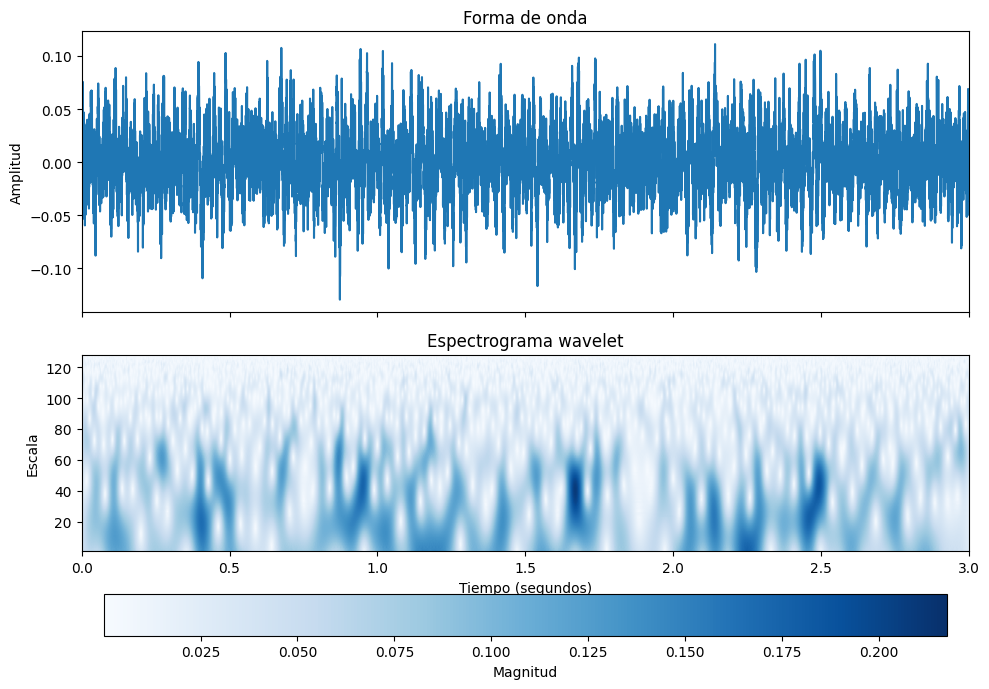

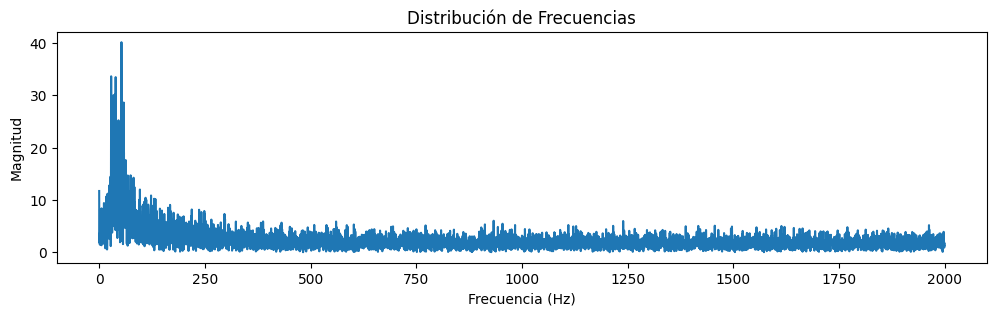

In [23]:
plot_wavelet_spectrogram(model_result.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(model_result.numpy(), sample_rate)
Audio(model_result, rate=sample_rate, autoplay=True)